In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

# Set options

In [2]:
THRESHOLD = 80
batch_corrected = True
nan_remove = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(nan_remove)+'_'+str(scaler_term)

# Load config files

In [3]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

# Get data

In [4]:
df = pd.read_excel(os.path.join(data_path,"raw_data.xlsx"))
n_classes = len(np.unique(df['Lipid Class']))
df.tail()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time\n(min),UNCORRECTED\nPeak Area of Lipid Species,UNCORRECTED\nPeak Area of Internal Standard,UNCORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),BATCH CORRECTED\nPeak Area of Lipid Species,BATCH CORRECTED\nPeak Area of Internal Standard,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
82147,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_20:4)-H,PG,825.6 / 303.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82148,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_20:5)-H,PG,823.5 / 301.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82149,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_22:4)-H,PG,853.6 / 331.3,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82150,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_22:5)-H,PG,851.6 / 329.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82151,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_22:6)-H,PG,849.6 / 327.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN


In [5]:
#sum(df.groupby('Sample Name')['Sample Submission Date'].unique() == '11/2022')
df['Individual Lipid Species'].nunique()

1141

## Select normalized or unnormalized data

In [6]:
metadata = df.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, df.iloc[:,19]],axis=1)
else:
    data = pd.concat([metadata, df.iloc[:,16]],axis=1)
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


## Organize pivot table

In [7]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Individual Lipid Species', values=data.columns[-1])
tot_lipids = data_pivot.shape[1] - 6

## Manage NaN

In [8]:
if nan_remove:
    data_stats = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
else:
    data_stats = data_pivot.reset_index().fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
data_stats.head()
lipids_ok = list(data_stats.columns[6:])

## Encode batch

In [9]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

## Log transform

In [10]:
data_np = data_stats.values[:,6:]
data_np = np.log10(data_np.astype('float64'))
print(data_np.shape)

(72, 372)


## Visualize data distribution

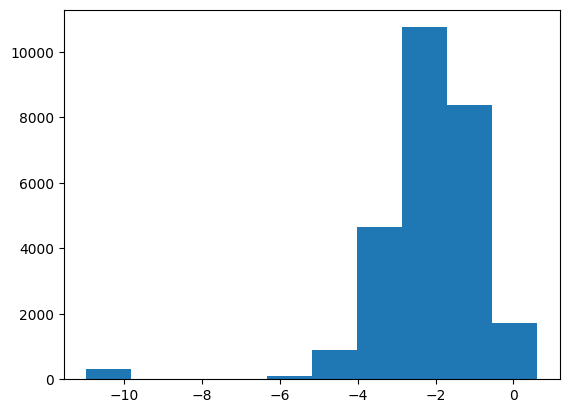

In [11]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

# Normalize data

In [12]:
data_norm = scaler.fit_transform(data_np)

## Visualize normalized data distribution

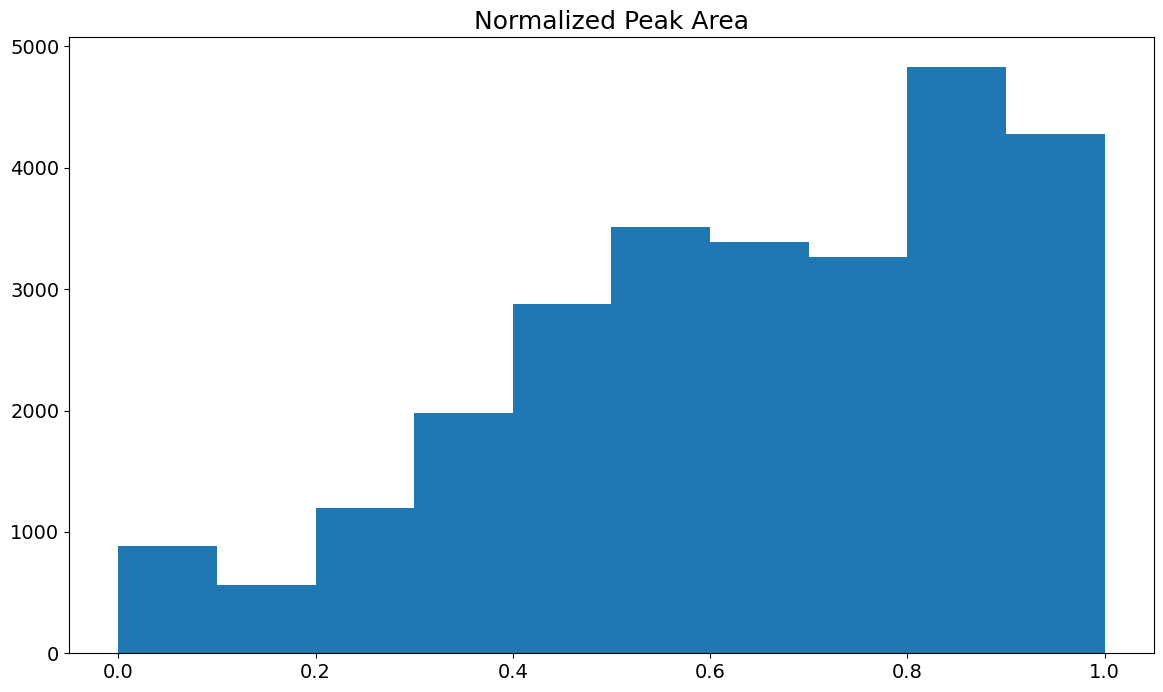

In [13]:
fig = plt.figure(figsize=(14,8), dpi=100)
plt.hist(data_norm.flatten())
plt.title('Normalized Peak Area', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('results/figure1.png')

# PCA

In [14]:
pca = PCA()
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(72, 72)


## Latent curve

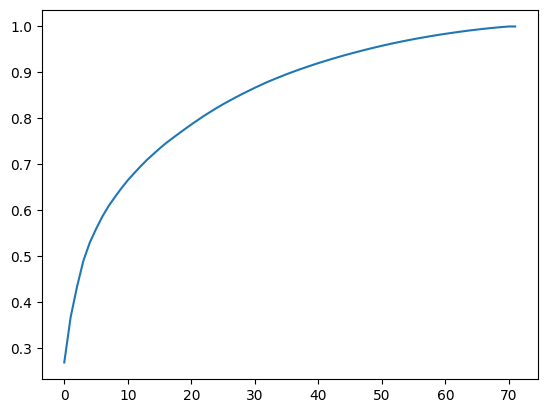

In [15]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# T-test

In [16]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(72, 3)


c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


# Visualize data after PCA

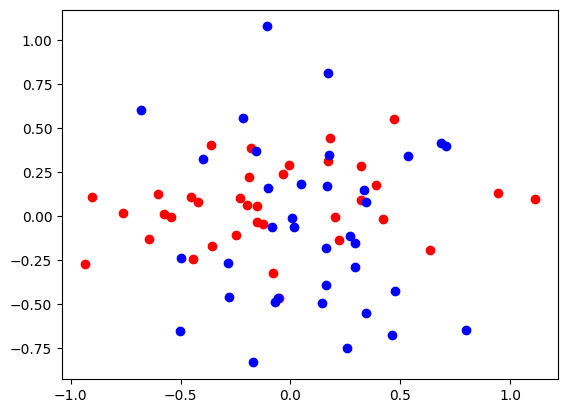

In [17]:
plt.scatter(data_pca[data_stats['Treatment']==0, 14], data_pca[data_stats['Treatment']==0, 21],c="red")
plt.scatter(data_pca[data_stats['Treatment']==1, 14], data_pca[data_stats['Treatment']==1, 21],c="blue")
plt.show()

# Isolate significant PCs

In [18]:
print(f'{np.sum(p_values[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values[:,2]<0.05)} significant pc with respect to date')
print(f'{np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc = np.where(p_values[:,2]<0.05)[0]

4 significant pc with respect to date
2 significant pc with respect to date
0 significant pc with respect to both


# Isolate significant lipids

In [19]:
significant_components = pca.components_[significant_pc,:]
print(significant_components.shape)
max_values = np.max(np.abs(significant_components), axis=0)
print(max_values.shape)

(2, 372)
(372,)


In [20]:
ths = np.percentile(np.abs(pca.components_.flatten()), THRESHOLD)
idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids = [lipids_ok[i] for i in idx_significant_lipids]

100 (8.81% of original total) significant lipids found


In [21]:
lipid_classes = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids])
print(f'{len(lipid_classes)} ({len(lipid_classes)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes)

17 (80.95% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPG' 'LPI' 'MAG' 'PC' 'PE'
 'PG' 'PI' 'PS' 'SM' 'TAG']


In [22]:
date_pc = np.where(p_values[:,1]<0.05)[0]
significant_components = pca.components_[date_pc,:]
max_values = np.max(np.abs(significant_components), axis=0)

idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) date dependent lipids found')
date_lipids = [lipids_ok[i] for i in idx_significant_lipids]

230 (20.26% of original total) date dependent lipids found


## Save results

In [23]:
with open(os.path.join('results','significant_lipid'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids:
        f.write(l+'\n')

with open(os.path.join('results','date_lipids'+test_enc_name+'.txt'), 'w') as f:
    for l in date_lipids:
        f.write(l+'\n')

with open(os.path.join('results','significant_lipid_classes'+test_enc_name+'.txt'), 'w') as f:
    for l in lipid_classes:
        f.write(l+'\n')

### EXAMPLE WITH PARTIAL LEAST SQUARE - DA

In [24]:
from sklearn.cross_decomposition import PLSRegression
pls2_treatment = PLSRegression(n_components=72, scale = False)
pls2_date = PLSRegression(n_components=72, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_norm, data_stats['Treatment'].values)
data_pls2_date = pls2_date.fit_transform(data_norm, data_stats['Sample Submission Date'].values)


c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cross_decomposition\_pls.py:302: UserWarning: Y residual is constant at iteration 56
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cross_decomposition\_pls.py:302: UserWarning: Y residual is constant at iteration 55
  warnings.warn(f"Y residual is constant at iteration {k}")


In [25]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_treatment[0][data_stats['Sample Submission Date']==0, d], data_pls2_treatment[0][data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pls2_treatment[0][data_stats['Treatment']==0, d], data_pls2_treatment[0][data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(72, 3)


In [26]:
data_pls2_treatment[0]  

array([[ 0.07473674,  1.42071025,  0.19214078, ...,  0.        ,
         0.        ,  0.        ],
       [-0.45257015,  0.7907593 ,  1.15392275, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.44833954,  1.2304216 , -0.88760168, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.73944258, -0.64421849, -2.70771404, ...,  0.        ,
         0.        ,  0.        ],
       [-0.08718034,  0.32392182,  0.45486872, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97806989, -1.19228261, -0.5760815 , ...,  0.        ,
         0.        ,  0.        ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


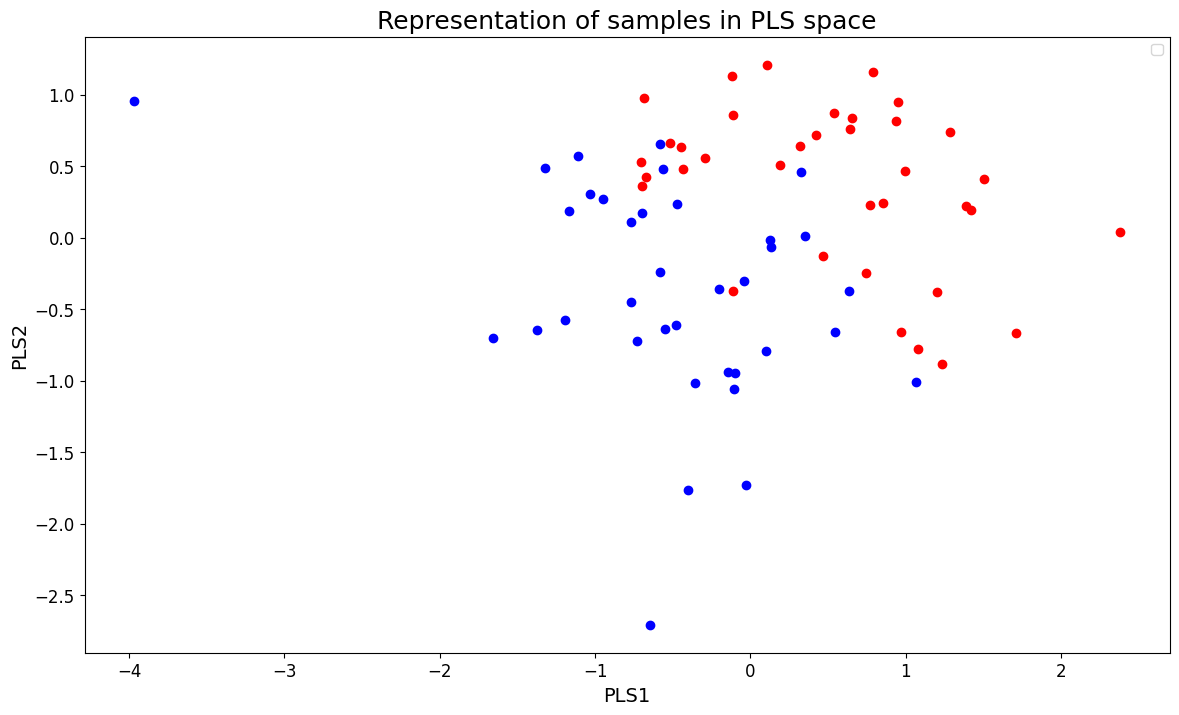

In [27]:
fig = plt.figure(figsize=(14,8), dpi=100)
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==0, 1], data_pls2_treatment[0][data_stats['Treatment']==0, 2],c="red")
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==1, 1], data_pls2_treatment[0][data_stats['Treatment']==1, 2],c="blue")
plt.legend()
plt.title('Representation of samples in PLS space', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('PLS1', fontdict={'fontsize':14})
plt.ylabel('PLS2', fontdict={'fontsize':14})
fig.savefig('results/figure2.png')

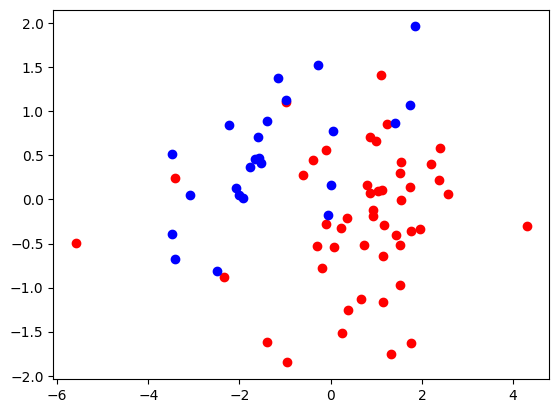

In [28]:
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==0, 0], data_pls2_date[0][data_stats['Sample Submission Date']==0, 1],c="red")
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==1, 0], data_pls2_date[0][data_stats['Sample Submission Date']==1, 1],c="blue")
plt.show()

In [29]:
p_values_pls2[[0,1,34,],:]

array([[0.00000000e+00, 2.07921749e-02, 3.59102371e-04],
       [1.00000000e+00, 1.50903515e-03, 8.22013374e-07],
       [3.40000000e+01, 2.72221251e-03, 9.99998950e-01]])

In [30]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values_pls2[:,2]<0.05)} significant pc with respect to TREATMENT')
print(f'{np.sum((p_values_pls2[:,2]<0.05)*(p_values_pls2[:,1]<0.05))} significant pc with respect to both')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,2]<0.05)[0]
significant_pc_pls2_date = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)
print(significant_pc_pls2_date)

3 significant pc with respect to date
5 significant pc with respect to TREATMENT
2 significant pc with respect to both
[0 1 2 3 4]
[ 0  1 34]


In [31]:
# we have 372x72 so 372 lypids composing each of the 72 components. We ahve to transapose them and isolate the components identified as the most significants
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
# and then we get the 372 highest lypids avlues acroos all th selcted components
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)

In [32]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T), THRESHOLD)

In [33]:
ths_pls2_treatment

0.05536853316619667

In [34]:
idx_significant_lipids_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_lipids_pls2_treatment = len(idx_significant_lipids_pls2_treatment)
print(f'{n_significant_lipids_pls2_treatment} ({n_significant_lipids_pls2_treatment/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_treatment = [lipids_ok[i] for i in idx_significant_lipids_pls2_treatment]
print(idx_significant_lipids_pls2_treatment)

298 (26.26% of original total) significant lipids found
[  0   1   2   3   4   6   7   8  11  12  13  14  15  16  18  19  21  22
  24  25  26  27  29  30  31  32  33  34  36  38  39  41  43  44  45  46
  47  48  49  51  53  54  56  57  58  59  60  61  62  63  65  66  67  68
  70  71  72  73  74  75  76  77  78  79  82  83  84  85  86  87  88  89
  90  91  92  93  94  96  97  98 100 101 103 106 109 110 111 112 113 114
 116 117 119 120 121 123 124 125 127 128 129 130 131 133 134 135 137 139
 140 141 142 143 144 145 146 149 150 151 153 154 155 156 158 159 160 161
 165 166 167 168 169 170 171 172 173 176 177 178 179 181 182 183 184 185
 186 187 189 190 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 219 220 221 222 223 224
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244
 246 249 250 252 253 254 255 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284

In [35]:
#significant_components_pls2_date = pls2_date.x_weights_.T[significant_pc_pls2_date,:]
#max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)

significant_components_pls2_date = pls2_treatment.x_weights_.T[significant_pc_pls2_date,:]
max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)

In [36]:
# we actually don'tneed this if we are working with the treatment components
#ths_pls2_date = np.percentile(np.abs(pls2_treatment.x_weights_.T), THRESHOLD)

In [37]:
""" idx_significant_lipids_pls2_date = np.where(max_values_pls2_date>ths_pls2_date)[0]
n_significant_lipids_pls2_date = len(idx_significant_lipids_pls2_date)
print(f'{n_significant_lipids_pls2_date} ({n_significant_lipids_pls2_date/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_date = [lipids_ok[i] for i in idx_significant_lipids_pls2_date] """

idx_significant_lipids_pls2_date = np.where(max_values_pls2_date>ths_pls2_treatment)[0]
n_significant_lipids_pls2_date = len(idx_significant_lipids_pls2_date)
print(f'{n_significant_lipids_pls2_date} ({n_significant_lipids_pls2_date/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_date = [lipids_ok[i] for i in idx_significant_lipids_pls2_date]

247 (21.76% of original total) significant lipids found


In [38]:
lipid_classes_pls2_treatment = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_treatment])
print(f'{len(lipid_classes_pls2_treatment)} ({len(lipid_classes_pls2_treatment)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_treatment)

18 (85.71% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPG' 'LPI' 'LPS' 'MAG' 'PC'
 'PE' 'PG' 'PI' 'PS' 'SM' 'TAG']


In [39]:
lipid_classes_pls2_date = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_date])
print(f'{len(lipid_classes_pls2_date)} ({len(lipid_classes_pls2_date)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_date)

16 (76.19% of original total) lipid classes found
['CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPI' 'LPS' 'MAG' 'PC' 'PE' 'PG'
 'PI' 'PS' 'SM' 'TAG']


In [40]:
unique_set_treatment = set(significant_lipids_pls2_treatment).difference(set(significant_lipids_pls2_date))
unique_list_treatment = list(unique_set_treatment)
len(unique_list_treatment)

75

In [41]:
with open(os.path.join('results','significant_lipids_pls2_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids_pls2_treatment:
        f.write(l+'\n')

In [42]:
with open(os.path.join('results','significant_lipids_pls2_date'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids_pls2_date:
        f.write(l+'\n')

In [43]:
with open(os.path.join('results','significant_lipids_pls2_unique_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in unique_list_treatment:
        f.write(l+'\n')